In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
from datetime import datetime, timedelta, date
%matplotlib inline

# Find most negative Feeds

## Intoroduction:

The objective of this analysis is to extract useful information from a dataset of feedback using sentiment analysis. 

Specifically, we will use the NLTK sentiment analyzer to classify feedback as positive, negative, or neutral, based on the sentiment expressed in the text.

To begin, we filtered the dataset to only include Tweets and used regular expressions to extract the relevant text from the "description" column. 

We then performed preprocessing steps such as removing punctuation and stop words, as well as applying stemming to the text.

The NLTK sentiment analyzer was then used to classify the feedback into positive, negative, or neutral categories. Finally, we utilized various visualization tools to analyze the results.

## Methodology:

The dataset was loaded using Pandas, and the relevant information was extracted using regular expressions.

The NLTK sentiment analyzer was used to classify feedback based on its sentiment.

The data was preprocessed using various techniques, including stop word removal and stemming.

## Load Data

In [55]:
df_0= pd.read_csv("Tweets.csv")[["tweet_created","airline", "text"]].rename(columns={'tweet_created':'created', "text":"description"})
df_0.head()

,created,airline,description
0,2015-02-24 11:35...,Virgin America,@VirginAmerica W...
1,2015-02-24 11:15...,Virgin America,@VirginAmerica p...
2,2015-02-24 11:15...,Virgin America,@VirginAmerica I...
3,2015-02-24 11:15...,Virgin America,@VirginAmerica i...
4,2015-02-24 11:14...,Virgin America,@VirginAmerica a...


## Filter data only with Tweets
## Convert data to datetime format and rename column and filter only "Virgin America" airlines

In [56]:

df = (
    df_0.copy()
    .query("airline == 'Virgin America' ")    
    .assign(
    created = lambda df_: pd.to_datetime(df_.created),
    date = lambda df_: df_.created.dt.date
    ).reset_index(drop=True).drop(columns= "created")
    )
df.head()

,airline,description,date
0,Virgin America,@VirginAmerica W...,2015-02-24
1,Virgin America,@VirginAmerica p...,2015-02-24
2,Virgin America,@VirginAmerica I...,2015-02-24
3,Virgin America,@VirginAmerica i...,2015-02-24
4,Virgin America,@VirginAmerica a...,2015-02-24


## Descriptive stats

we see that we have 3300 records and min date is 1st of january and max is 20th of january 2022

In [57]:
df.describe(include="all", datetime_is_numeric= True)

,airline,description,date
count,504,504,504
unique,1,503,8
top,Virgin America,@VirginAmerica T...,2015-02-23
freq,504,2,91


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   airline      504 non-null    object
 1   description  504 non-null    object
 2   date         504 non-null    object
dtypes: object(3)
memory usage: 11.9+ KB


In [59]:
strings= df.description

##  PreProcessing Email body data

### Replace all numbers from email body
find any symbols and digits other than alphabets and replace with space.

In [60]:
df['body'] = df.description.str.replace(r'\d+', " ", regex=True)
df['body_1'] = df.body.str.replace('[^a-zA-Z]', " ", regex=True)
df.head(2)

,airline,description,date,body,body_1
0,Virgin America,@VirginAmerica W...,2015-02-24,@VirginAmerica W...,VirginAmerica W...
1,Virgin America,@VirginAmerica p...,2015-02-24,@VirginAmerica p...,VirginAmerica p...


###  Remove punctuations 
* we can do this either by using str.replace of pandas like below 
* ^ symbol when used inseside [^a-zA-Z] means find any word other than alphabets

In [61]:
import string
df_with_punc = df.head().copy()
df = (
    df
    .assign (
        body_1 = df.body.str.replace(r'[^a-zA-Z\s]+','', regex=True).str.lower()        
    ).reset_index(drop=True)
)
df.body_1.head(2)

0    virginamerica wh...
1    virginamerica pl...
Name: body_1, dtype: object

## import libraries for analysis

In [62]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop_words  = stopwords.words('english')
stemming = SnowballStemmer(language = 'english')
" ".join(stop_words)

"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"

## Remove stop words 

In [63]:
df['body_1'] = df.body_1.apply(lambda x : (" ").join([word for word in word_tokenize(x) if not word in stop_words]))
df.head(2)

,airline,description,date,body,body_1
0,Virgin America,@VirginAmerica W...,2015-02-24,@VirginAmerica W...,virginamerica dh...
1,Virgin America,@VirginAmerica p...,2015-02-24,@VirginAmerica p...,virginamerica pl...


### Use Stemming, (means converting words like running, walking to run, walk)

In [64]:
df['body_1'] = df.body_1.apply(lambda x : (" ").join([stemming.stem(word) for word in x.split()]))
df.body_1.head(2)

0    virginamerica dh...
1    virginamerica pl...
Name: body_1, dtype: object

## NLTP Sentiment Analyser

In [65]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download()
sia= SentimentIntensityAnalyzer()

In [66]:
pol_test = df.body_1
df_sent_results = pd.DataFrame([sia.polarity_scores(word) for word in pol_test])

In [67]:
df_sent_results.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.169,0.662,0.169,0.0000
4,0.467,0.533,0.000,-0.5423


Nltk setntiment analyser which gives us positive, negative, neutral and compound number.
Positive compound means its an over all positive sentiment and negative means its overall negative sentiment.

In [68]:
df_final_results =pd.concat([df, df_sent_results], axis=1)
df.head()

,airline,description,date,body,body_1
0,Virgin America,@VirginAmerica W...,2015-02-24,@VirginAmerica W...,virginamerica dh...
1,Virgin America,@VirginAmerica p...,2015-02-24,@VirginAmerica p...,virginamerica pl...
2,Virgin America,@VirginAmerica I...,2015-02-24,@VirginAmerica I...,virginamerica di...
3,Virgin America,@VirginAmerica i...,2015-02-24,@VirginAmerica i...,virginamerica re...
4,Virgin America,@VirginAmerica a...,2015-02-24,@VirginAmerica a...,virginamerica re...


## Lets pick up one of the negative score feedbacks


the below table shows the top negative sentiment score records.

In [69]:
df_final_results.drop(columns=["description", "body_1"]).sort_values("compound").head(5)

,airline,date,body,neg,neu,pos,compound
249,Virgin America,2015-02-21,@VirginAmerica -...,0.503,0.497,0.0,-0.8779
434,Virgin America,2015-02-18,@VirginAmerica V...,0.511,0.489,0.0,-0.8126
187,Virgin America,2015-02-21,@VirginAmerica ...,0.545,0.455,0.0,-0.8020
262,Virgin America,2015-02-20,@VirginAmerica #...,0.451,0.549,0.0,-0.8020
157,Virgin America,2015-02-22,@VirginAmerica h...,0.403,0.597,0.0,-0.7964


In [70]:
df_final_results.body[249]

"@VirginAmerica - the passenger in  D, Flt   that assaulted me shouldn't have flown. I trust he's banned. Crew filed report to @FAANews"

It seems like our SentimentIntensityAnalyzer did pick it up correctly as it is quite a begative experience

The plot below shows the graph for the words which appear in highest frequency in negative sentiment records.

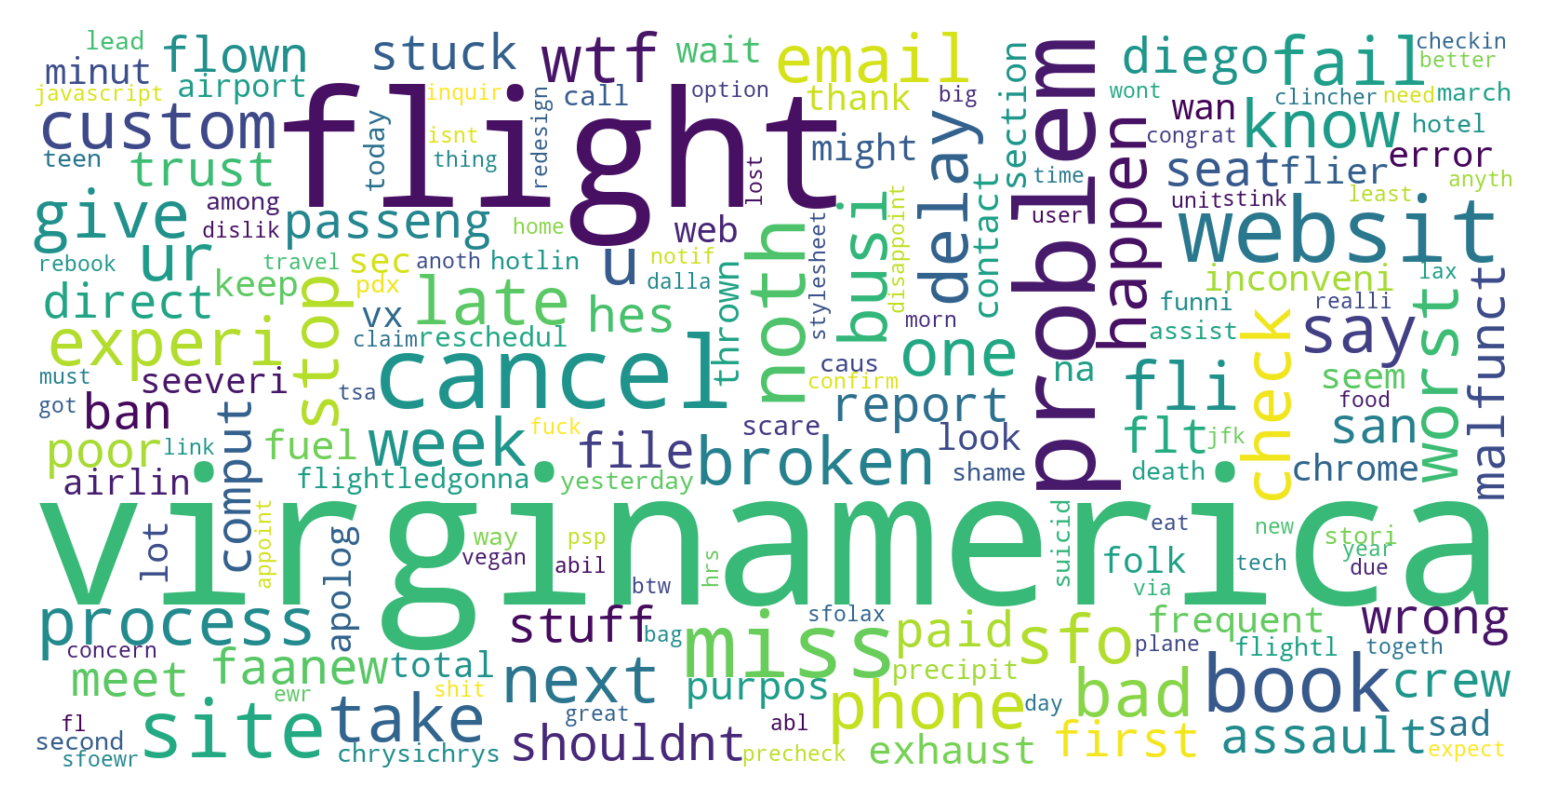

In [71]:
from wordcloud import WordCloud

plt.figure(dpi= 300)

text = df_final_results.sort_values("compound").query("compound < -.5").body_1.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=350, max_words= 500, background_color="white",width=1600, height=800,
                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

## Lets pick up one of the positive score feedbacks

the below table shows the top positive sentiment score records.

In [72]:
df_final_results.drop(columns=["description", "body_1"]).sort_values("compound", ascending= False).head(3)

,airline,date,body,neg,neu,pos,compound
68,Virgin America,2015-02-23,@VirginAmerica C...,0.0,0.410,0.590,0.9100
379,Virgin America,2015-02-19,@VirginAmerica J...,0.0,0.579,0.421,0.8979
74,Virgin America,2015-02-23,@VirginAmerica n...,0.0,0.395,0.605,0.8934


In [79]:
df_final_results.body[379]

'@VirginAmerica Just bought tix for ATX - Dallas route - thanks for adding that! Love yr airline &amp; yr website is BEST transactional site EVER'

An the above record shows a positive sentiment correctly

The plot below shows the graph for the words which appear in highest frequency in negative sentiment records.

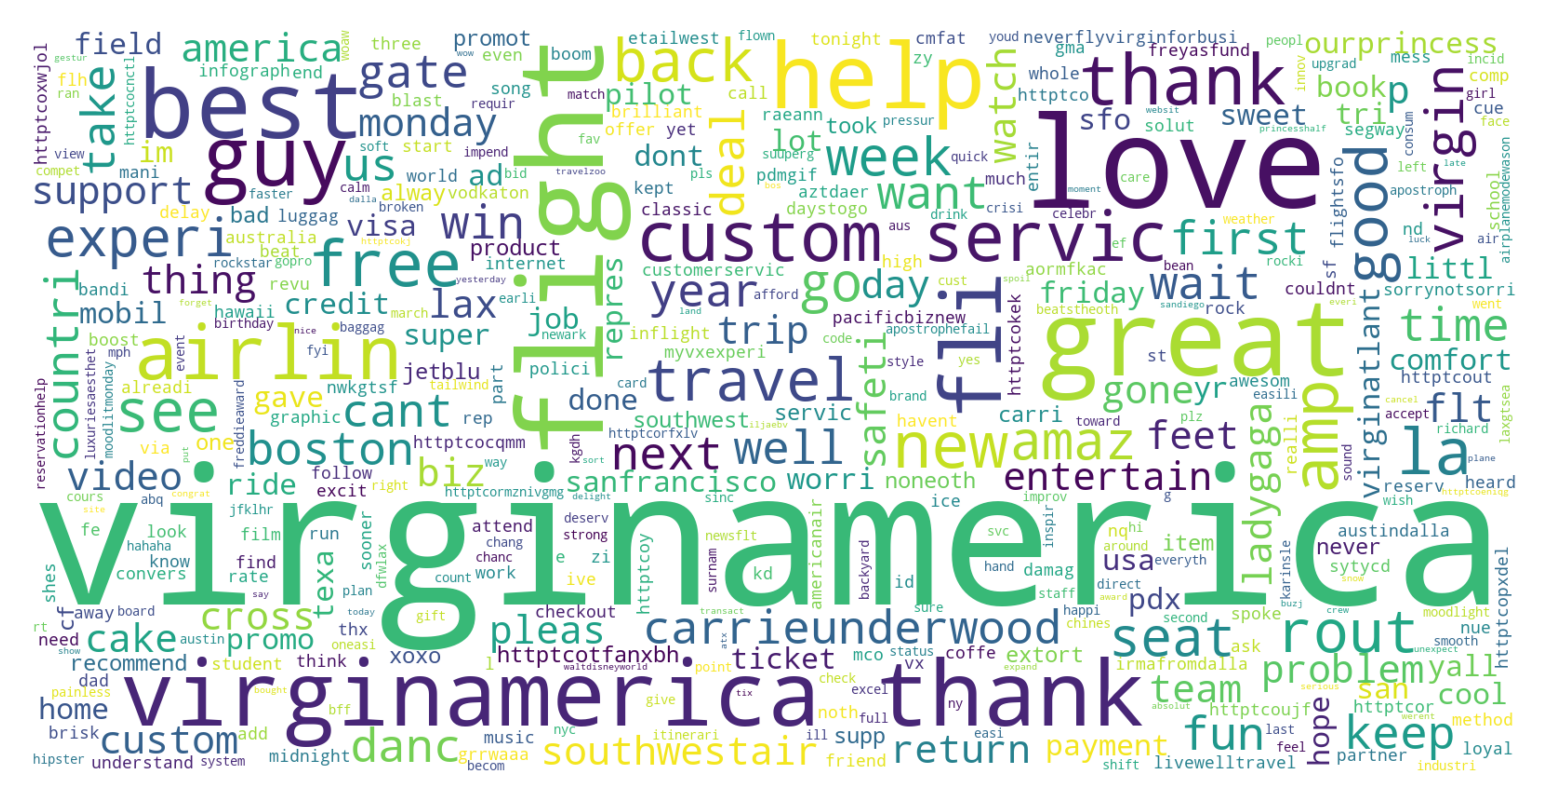

In [74]:
from wordcloud import WordCloud

plt.figure(dpi=300)

text = df_final_results.sort_values("compound").query("compound > .6").body_1.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=250, max_words= 500, background_color="white",width=1600, height=800, 
                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

Plot shows the average sentiment from 1st of january to the end of january. We notice that overal sentiment is positve however in the early january it is on its lowest and gradually starts 
to increase and by the middle of the month it is at highest.

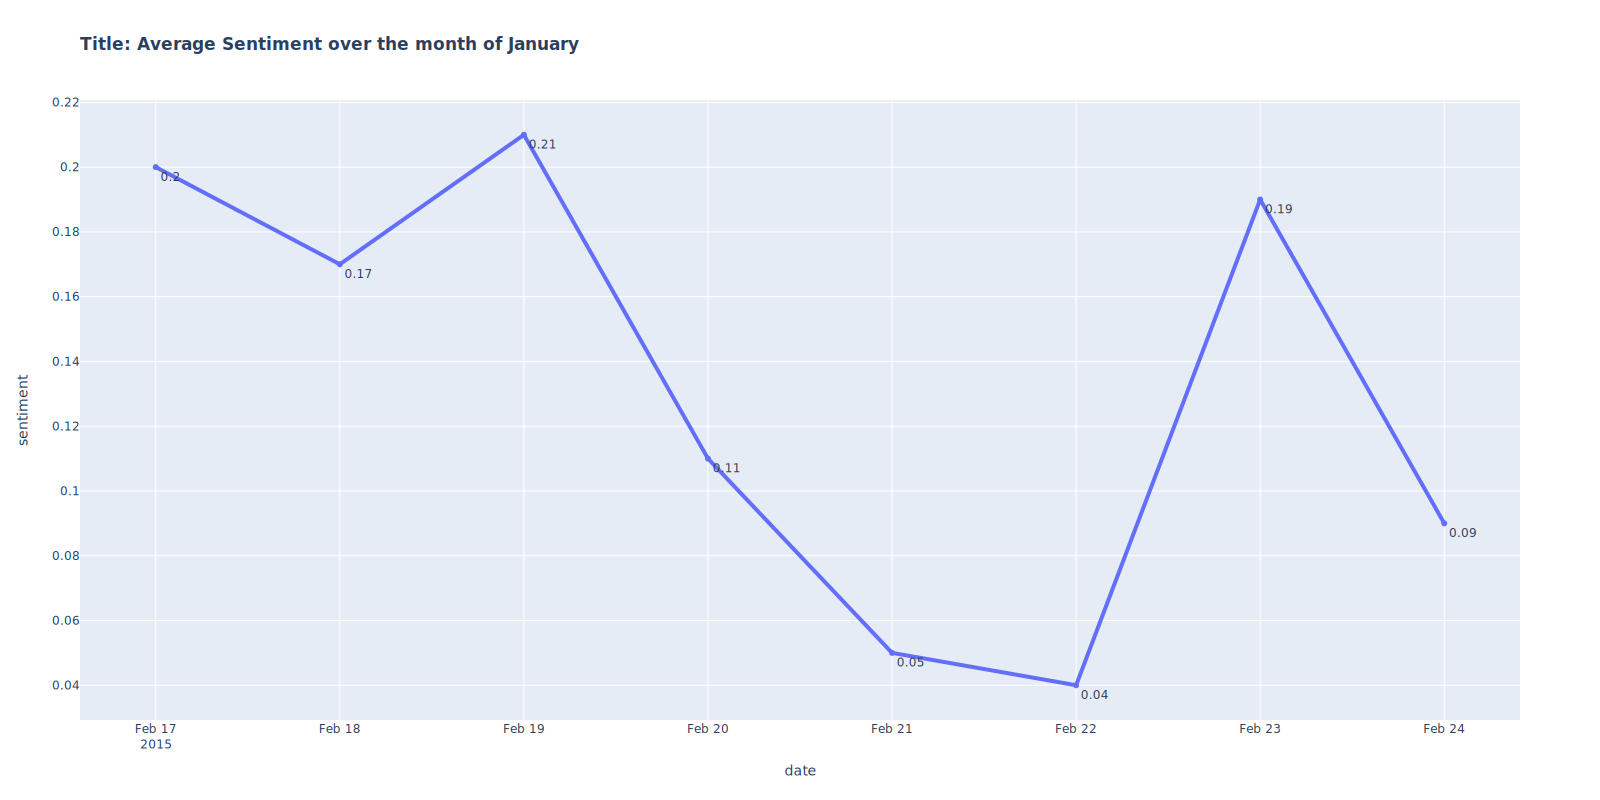

In [75]:
pd.set_option( 'display.max_columns' , 150,'display.max_rows' , 100,'display.max_colwidth', 20)
(
    df_final_results.sort_values("compound")    
    .groupby("date", as_index=False).agg(sentiment= ("compound", "mean"))  
    .round(2)  
    .plot.line(x= "date", y = "sentiment", width= 1600, height = 800, text = "sentiment", 
               title= "<b> Title: Average Sentiment over the month of January </b>")
    .update_traces(textposition="bottom right", line= {"width":4})         
).show("svg")

Plot below shows the total number of positive, negative and neutral sentiment records
we see overall we have positive and neutral sentiment sentiment with 91 negative records of 206 and 207 neutral and positive respectively.

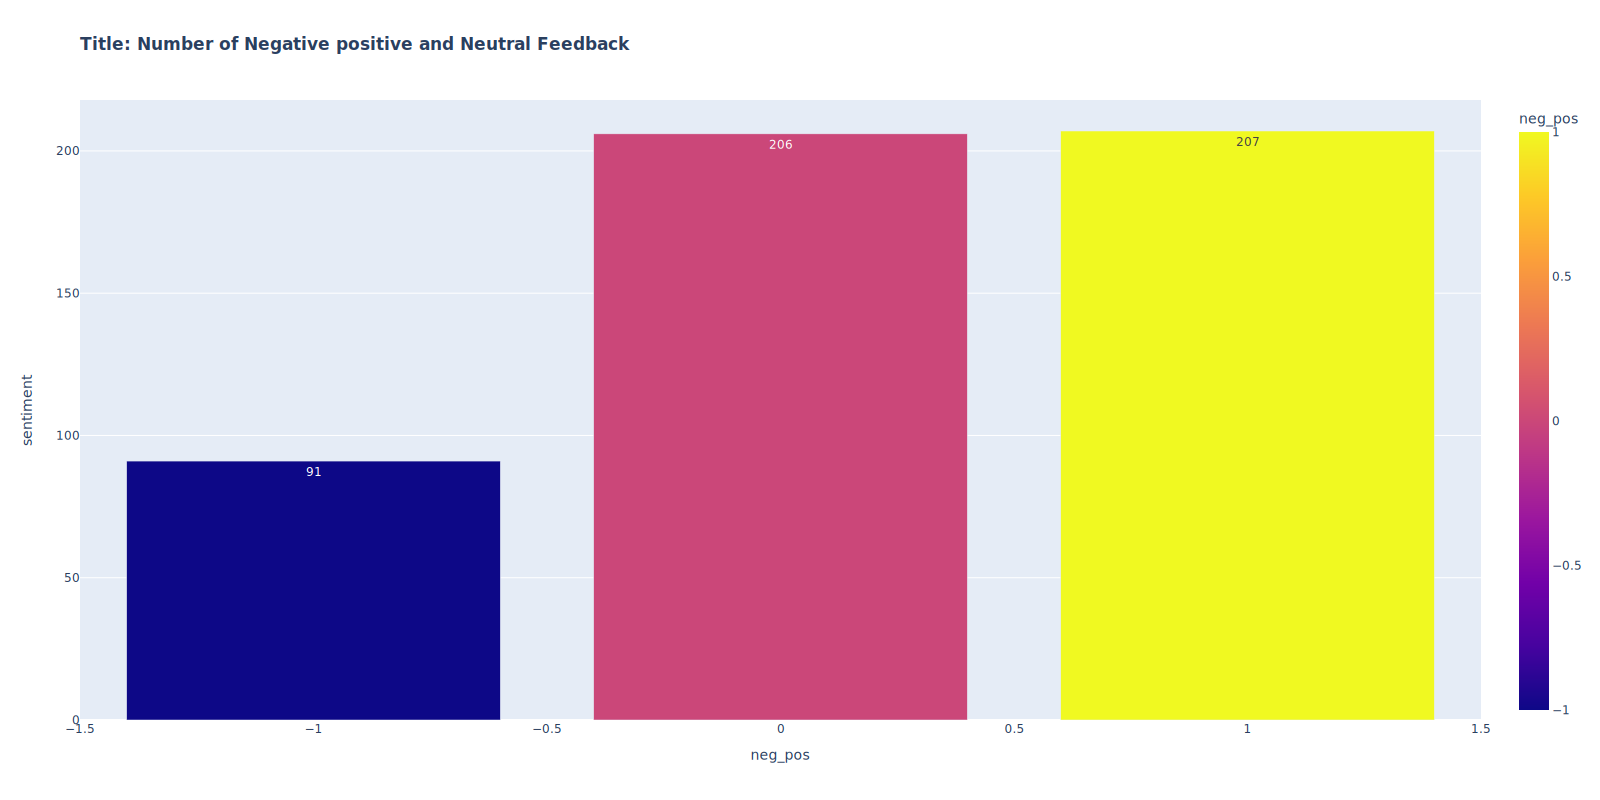

In [76]:
(
    df_final_results.sort_values("compound")
    .assign(neg_pos= lambda df_: np.where(df_.compound < -.1, -1,
                                np.where(df_.compound > .1, 1 , 0))
            )
    .groupby("neg_pos", as_index=False).agg(sentiment= ("compound", "count"))    
.plot.bar(x= "neg_pos", y = "sentiment", color="neg_pos", text_auto = True, 
          width= 1600, height = 800,
          title= "<b> Title: Number of Negative positive and Neutral Feedback </b>"
          )
).show("svg")

plot showing the min, max and interquartile range of the scores

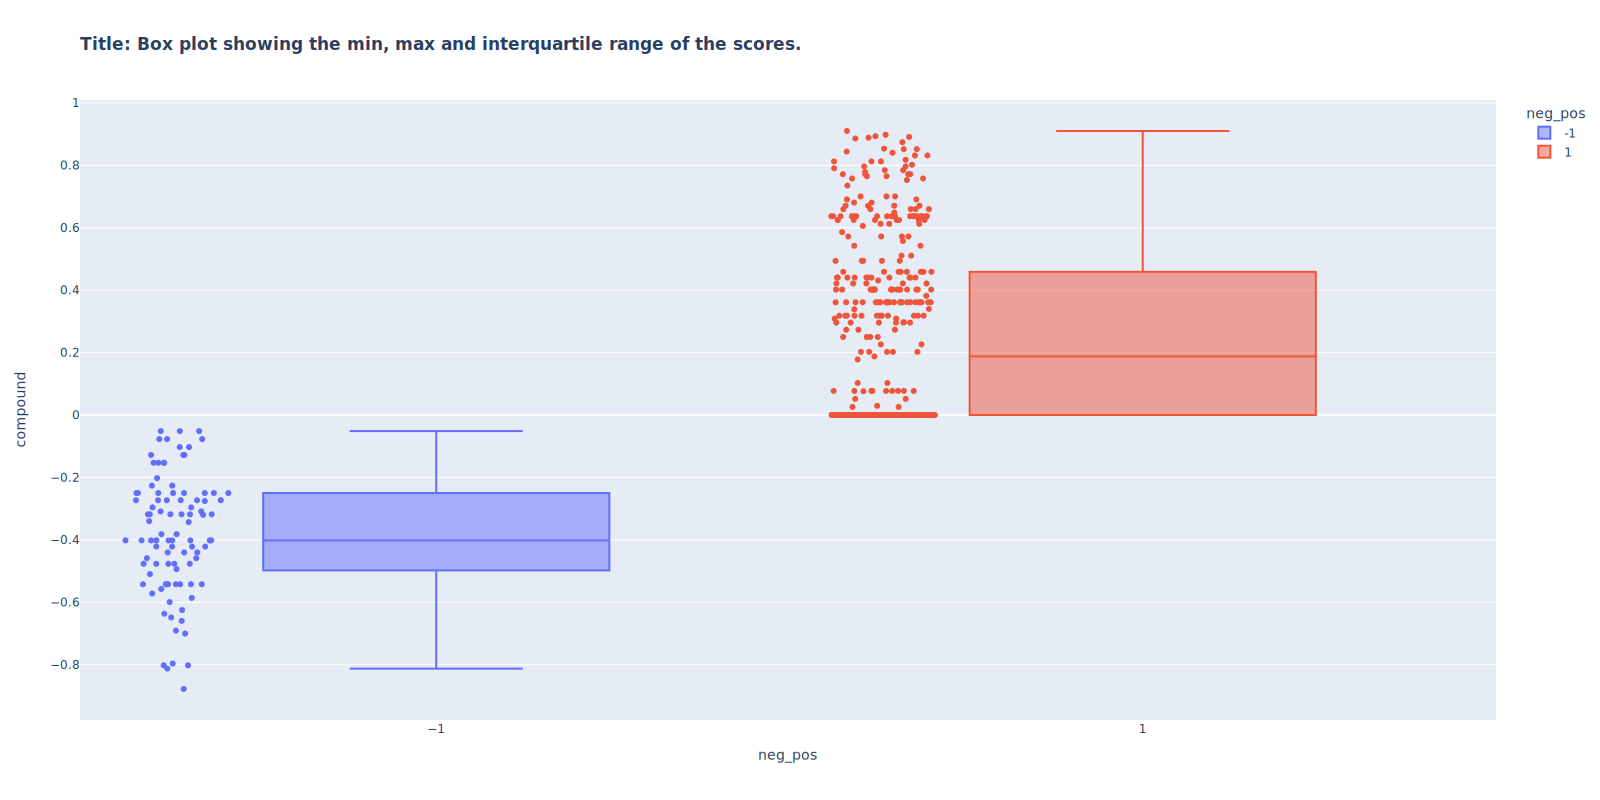

In [77]:
(    df_final_results.sort_values("compound")
    .assign(neg_pos= lambda df_: np.where(df_.compound < -0, -1,
                                np.where(df_.compound >= 0, 1 , 0))
            )     
.plot.box(x= "neg_pos", y = "compound", color="neg_pos", 
          width= 1600, height = 800, points="all",
          title= "<b> Title: Box plot showing the min, max and interquartile range of the scores.</b>"          
          )
).show("svg")

## Results:

The analysis revealed that the majority of the feedback was negative. 

We found that customers were mainly complaining about issues realted to assault by another passenger on the plane.

The analysis also showed that there was a significant increase in negative feedback during a specific period of feb20th to 22, which may have been due to a change in the company's policies or practices.

## Conclusion

This analysis demonstrates the importance of sentiment analysis in understanding customer feedback. 

By using the NLTK sentiment analyzer and various preprocessing techniques, we were able to extract meaningful insights from the dataset. 

These insights can be used to improve the quality of the product or service and enhance customer satisfaction.